In [30]:
import pandas as pd
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import re
from sklearn.model_selection import KFold
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as LGBM
from scipy.stats import ttest_ind
import scipy as sp
import scipy.stats as stats
import shap
import gc
import os
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)

source_folder = os.getcwd()
path_save = os.path.join(source_folder, 'Data')

sep = r'/'

In [32]:
df = pd.read_csv(path_save+sep+'BASE_FINAL.csv',
                sep=';', decimal=',', encoding='latin-1')

numerics = ['PS/G','PA/G','SRS','MOV','ORtg','DRtg','NRtg','MOV/A','ORtg/A','DRtg/A','NRtg/A']

df = df.drop(columns=numerics)

#df = df[(df['Seed']<=16)|(df['CLASSE']>0)]
#df = df[(df['W/L%']>0.5)]

df.head()

,Tm,W/L%,Seed,Rank_PS/G,Rank_PA/G,Rank_SRS,COACHES_Seasons_Franchise,COACHES_Seasons_Career,Age,ALL_STAR,...,Rank_DRtg,Rank_NRtg,Rank_MOV/A,Rank_ORtg/A,Rank_DRtg/A,Rank_NRtg/A,Season,CLASSE,Champion_Share_Previous_Season,Champion_Share_Last_3_Seasons
0,ATL,0.488,13,22,2,14,2.0,2.0,26.916667,0.0,...,14,15,14,16,16,14,1984,0.133333,0.000000,0.000000
1,ATL,0.415,17,17,4,15,3.0,3.0,25.500000,0.0,...,17,15,15,15,16,15,1985,0.000000,0.133333,0.133333
2,ATL,0.610,6,16,6,4,4.0,4.0,24.833333,1.0,...,13,5,4,10,14,4,1986,0.266667,0.000000,0.066667
3,ATL,0.695,3,11,1,2,5.0,5.0,26.230769,1.0,...,9,2,2,4,10,2,1987,0.266667,0.266667,0.133333
4,ATL,0.610,8,11,4,4,6.0,6.0,26.545455,2.0,...,21,7,4,4,19,4,1988,0.400000,0.266667,0.177778


In [33]:
seasons_train = [1984, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994,
                   1995, 1996, 1998, 1999, 2001, 2003, 2005, 2006, 2007, 2009,
                   2011, 2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021]
seasons_test = [1990, 1997, 2000, 2002, 2004, 2008, 2010, 2015, 2017, 2022, 2023, 2024]

treino = df[df['Season'].isin(seasons_train)]
teste = df[df['Season'].isin(seasons_teste)]

print(len(teste)/(len(treino)+len(teste)))

0.3042720139494333


## Grid Search

In [8]:
Xtest = teste.drop(columns=['CLASSE','Season','Tm']).reset_index(drop=True)
ytest = teste['CLASSE'].reset_index(drop=True)

Xtr = treino.drop(columns=['CLASSE','Season','Tm']).reset_index(drop=True)
ytr = treino['CLASSE'].reset_index(drop=True)

In [56]:
K=5

kfold = KFold(n_splits = K, random_state = 231, shuffle = True) 

model_dict={'LGBM':{'learning_rate':[0.01,0.1,0.2], # 1°
                     'objective':['regression'],
                     'max_depth':[-1],
                     'num_leaves':[10,15,20,30,50], # 1º
                     'min_data_in_leaf':[5,10,20], # 1º
                     'is_unbalance':[False],
                     'feature_fraction':[0.1,0.5,0.9], # 2º
                     'bagging_fraction':[0.1,0.5,0.9], # 2º
                     'lambda_l1':[0.01,0.1,1], #3º
                     #'lambda_l2':[1], #3º
                     'verbosity':[-1],
                     'metric':['rmse'],
                     'seed':[1],
                     #"boosting_type": ["gbdt",'dart'],
                     'device_type' : ['cpu'],
                     'early_stopping_rounds':[800],
                     'num_boost_round':[80000],
                     #"gpu_platform_id": [0],
                     #"gpu_device_id": [0],
                     #'SCALER':[False]
                   }}

final_results=pd.DataFrame()
test_results=pd.DataFrame()

n_metrics=4

metrics=np.zeros((n_metrics,K))

shap_mean=0
shapps=False

save=False

features = list(Xtest.columns)
#to_categ = [col for col in features if col.endswith('_categ')]

In [57]:
for model in model_dict.keys():
       
    for p in itertools.product(*model_dict[model].values()):
         
        model_=eval(model)

        parameters=dict(zip(model_dict[model].keys(),p))
            
        parameters_check = {x:y for x,y in parameters.items() if x!='SCALER'}

        if final_results.empty == False:   
            if str(parameters_check) in final_results['parameters'].to_list() :
                print('Parametro já avaliado')
                continue

        lr_probs_test=0
        #lr_probs_test = np.zeros(len(Xtest))
        lr_probs_val=0

        for i, (f_ind, outf_ind) in enumerate(kfold.split(Xtr, ytr)):
            z=0
    
            X_train = Xtr.loc[f_ind].reset_index(drop=True)
            y_train = ytr.loc[f_ind].reset_index(drop=True)

            X_val=Xtr.loc[outf_ind]
            y_val=ytr.loc[outf_ind]
            
            d_train, d_valid = train_test_split(X_train,test_size=.15,random_state=3)

            Xt = X_train.loc[d_train.index].copy()
            yt = y_train.loc[d_train.index].copy()

            d_train, d_valid = train_test_split(Xt,test_size=.3,random_state=3)
            
            Xv2 = Xt.loc[d_valid.index].copy()
            yv2 = yt.loc[d_valid.index].copy()
            
            Xtt2 = Xt.loc[d_train.index].copy()
            ytt2 = yt.loc[d_train.index].copy()
            
            d_train = LGBM.Dataset(Xtt2.loc[:,features], label = ytt2, 
                                   feature_name = features,
                                   #categorical_feature=to_categ
                                  )

            d_val = LGBM.Dataset(Xv2.loc[:,features], label = yv2, 
                                 feature_name = features,
                                 #categorical_feature=to_categ
                                )

            in_list=['num_boost_round','feval']

            parameters_in={x:parameters[x] for x in parameters if x in in_list }

            parameters_out={x:parameters[x] for x in parameters if x not in in_list }

            model_=eval(model)
            
            model_t=model_.train(parameters_out,train_set=d_train,
                                valid_sets =[d_train,d_val],
                                callbacks=[LGBM.early_stopping(stopping_rounds=800),LGBM.log_evaluation(500)],
                                num_boost_round=80000,
                                #categorical_feature=to_categ
                                )
            
            lr_probs_test += model_t.predict(Xtest.loc[:,features])

            lr_probs = model_t.predict(X_val.loc[:,features])
            
            lr_probs_t = model_t.predict(Xtt2.loc[:,features])

            metrics[0,i] = mean_squared_error(y_val, lr_probs, squared=False)
            metrics[1,i] = mean_squared_error(ytt2, lr_probs_t, squared=False)
            
            metrics[2,i] = r2_score(y_val, lr_probs)
            metrics[3,i] = r2_score(ytt2, lr_probs_t)
    
        means=metrics.mean(1)
        deviation=metrics.std(1,ddof=1)
        print('MSE: %.3f' %(means[0]))
        print('R2: %.3f' %(means[2]))
    
        lr_probs_test /= K
        lr_probs_val=lr_probs_val/K
    
        test_RMSE = mean_squared_error(ytest, lr_probs_test, squared=False)
        test_R2 = r2_score(ytest, lr_probs_test)
        
        print('test_RMSE: %.3f' %(test_RMSE))
        print('test_R2: %.3f' %(test_R2))
       
        results=pd.DataFrame([{'Model':model,
                              'parameters':parameters,
                              'RMSE_train':means[1],
                              'RMSE_val':means[0],
                              'RMSE_test':test_RMSE,
                              'RMSE_val_std':deviation[0],
                              'R2_train':means[3],
                              'R2_val':means[2],
                              'R2_test':test_R2,
                              'R2_val_std':deviation[2]}])

        final_results=pd.concat([final_results,results],ignore_index=True)

        final_results.to_csv(os.path.join(path_save,"LGBM_CLUSTER.csv"),
                             sep=';',decimal=',',encoding='utf-8',
                             index=False)


Training until validation scores don't improve for 800 rounds
[500]	training's rmse: 0.122651	valid_1's rmse: 0.242492
Training until validation scores don't improve for 800 rounds
[500]	training's rmse: 0.129334	valid_1's rmse: 0.245826
[1000]	training's rmse: 0.120463	valid_1's rmse: 0.247216
Early stopping, best iteration is:
[207]	training's rmse: 0.176767	valid_1's rmse: 0.237241
Training until validation scores don't improve for 800 rounds
[500]	training's rmse: 0.131528	valid_1's rmse: 0.208353
[1000]	training's rmse: 0.124079	valid_1's rmse: 0.208449
Training until validation scores don't improve for 800 rounds
[500]	training's rmse: 0.125045	valid_1's rmse: 0.214913
[1000]	training's rmse: 0.117842	valid_1's rmse: 0.216815
Early stopping, best iteration is:
[210]	training's rmse: 0.159689	valid_1's rmse: 0.209103
Training until validation scores don't improve for 800 rounds
[500]	training's rmse: 0.129189	valid_1's rmse: 0.239428
[1000]	training's rmse: 0.127122	valid_1's rmse

In [58]:
final_results.sort_values('RMSE_val')['parameters'].iloc[0]

{'learning_rate': 0.01,
 'objective': 'regression',
 'max_depth': -1,
 'num_leaves': 10,
 'min_data_in_leaf': 20,
 'is_unbalance': False,
 'lambda_l1': 1,
 'verbosity': -1,
 'metric': 'rmse',
 'seed': 1,
 'device_type': 'cpu',
 'early_stopping_rounds': 800,
 'num_boost_round': 80000}

## Final Training

In [34]:
features = list(teste.drop(columns=['CLASSE','Tm','Season']).columns)

Xtest = teste[features].reset_index(drop=True)
ytest = teste['CLASSE'].reset_index(drop=True)

Xtr = treino[features].reset_index(drop=True)
ytr = treino['CLASSE'].reset_index(drop=True)

d_train, d_valid = train_test_split(Xtr,test_size=.25,random_state=3)

Xt = Xtr.loc[d_train.index].reset_index(drop=True).copy()
yt = ytr.loc[d_train.index].reset_index(drop=True).copy()

Xv = Xtr.loc[d_valid.index].reset_index(drop=True).copy()
yv = ytr.loc[d_valid.index].reset_index(drop=True).copy()

d_train = LGBM.Dataset(Xt.loc[:,features], label = yt, 
                      feature_name = features,
                       #categorical_feature=categories
                      )

d_val = LGBM.Dataset(Xv.loc[:,features], label = yv, 
                    feature_name = features,
                     #categorical_feature=categories
                    )

In [35]:
model_dict={# Atualizar escolhendo AUC_train
            'LGBM':{'learning_rate':[0.2], # 1°
                     'objective':['regression'],
                     'max_depth':[-1],
                     'num_leaves':[10], # 1º
                     'min_data_in_leaf':[30], # 1º
                     'is_unbalance':[False],
                     'feature_fraction':[0.5], # 2º
                     'bagging_fraction':[0.1], # 2º
                     'lambda_l1':[0.1], #3º
                     #'lambda_l2':[1], #3º
                     'verbosity':[-1],
                     'metric':['rmse'],
                     'seed':[1],
                     #"boosting_type": ["gbdt",'dart'],
                     'device_type' : ['cpu'],
                     #"gpu_platform_id": [0],
                     #"gpu_device_id": [0],
                     #'SCALER':[False]
                   }}


model_ = eval(list(model_dict.keys())[0])

for model in model_dict.keys():
    for p in itertools.product(*model_dict[model].values()):
        parameter=dict(zip(model_dict[model].keys(),p))

in_list = ['num_boost_round','early_stopping_rounds','verbose_eval']

parameters_in = {x:parameter[x] for x in parameter if x in in_list}

parameters_out = {x:parameter[x] for x in parameter if x not in in_list}

model_t_lgbm = model_.train(parameters_out,train_set=d_train,
                             valid_sets =[d_train,d_val],
                            #categorical_feature=categories,
                             **parameters_in)

pickle.dump(model_t_lgbm,open(os.path.join(path_save,'model_LGBM.dat'),'wb'))

In [36]:
model_t_lgbm = pickle.load(open(os.path.join(path_save,'model_LGBM.dat'),'rb'))
features = list(teste.drop(columns=['CLASSE','Tm','Season']).columns)

Xtest['CLASSE'] = ytest

Xtest['SCORE'] = model_t_lgbm.predict(Xtest.loc[:,features])
Xtest = Xtest.sort_values(by='SCORE')

Xtr['CLASSE'] = ytr

Xtr['SCORE'] = model_t_lgbm.predict(Xtr.loc[:,features])
Xtr = Xtr.sort_values(by='SCORE')

## Metrics

In [37]:
train_RMSE = mean_squared_error(Xtr['CLASSE'], Xtr['SCORE'], squared=False)
train_R2 = r2_score(Xtr['CLASSE'], Xtr['SCORE'])

test_RMSE = mean_squared_error(Xtest['CLASSE'], Xtest['SCORE'], squared=False)
test_R2 = r2_score(Xtest['CLASSE'], Xtest['SCORE'])

print('Train RMSE: ',train_RMSE)
print('Test RMSE: ',test_RMSE)
print('\nTrain R2: ',train_R2)
print('Test R2: ',test_R2)

Train RMSE:  0.09744743201552802
Test RMSE:  0.1841810325640158

Train R2:  0.8737382535302091
Test R2:  0.5365764892010874


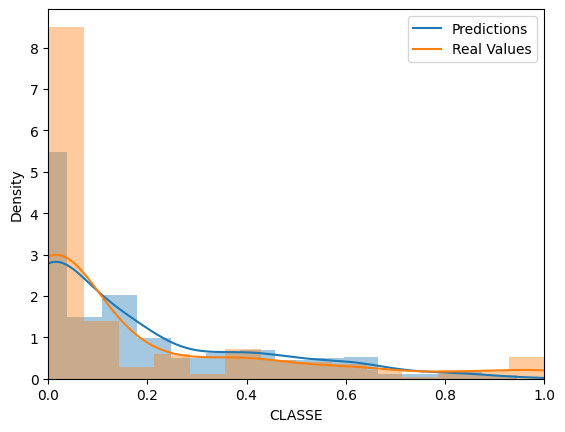

In [38]:
# Distribuções
sns.distplot(Xtest['SCORE'])
sns.distplot(Xtest['CLASSE'])
plt.legend(['Predictions','Real Values'])
plt.xlim(0,1);

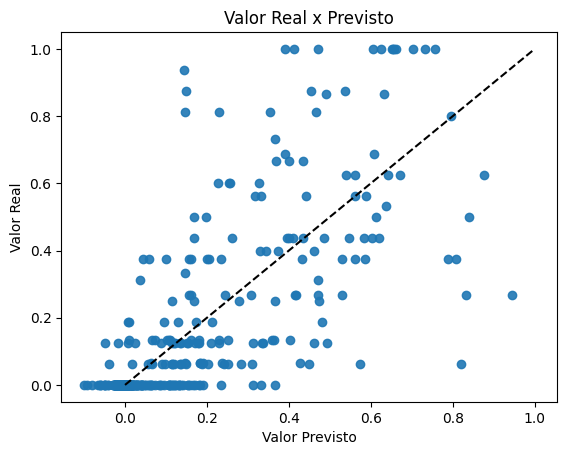

In [39]:
x = np.arange(0, 1.01, 0.1)
y = x
plt.scatter(Xtest['SCORE'],Xtest['CLASSE'], alpha=0.9)
plt.plot(x, y, color='k', linestyle='--')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Valor Real x Previsto');

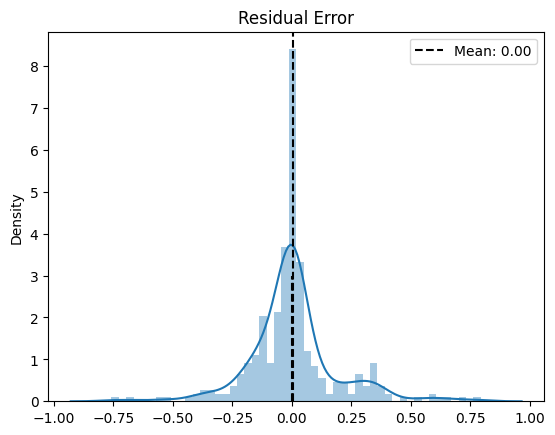

In [40]:
residuos = Xtest['CLASSE'] - Xtest['SCORE']
sns.distplot(residuos)
plt.vlines(0,ymin=0,ymax=3,color='k',linestyles='--')
plt.axvline(residuos.mean(), color='black', linestyle='dashed', label=f'Mean: {residuos.mean():.2f}')
#plt.axvline(residuos.median(), color='green', linestyle='dashed', label=f'Mediana: {residuos.median():.2f}')
plt.legend()
plt.title('Residual Error');

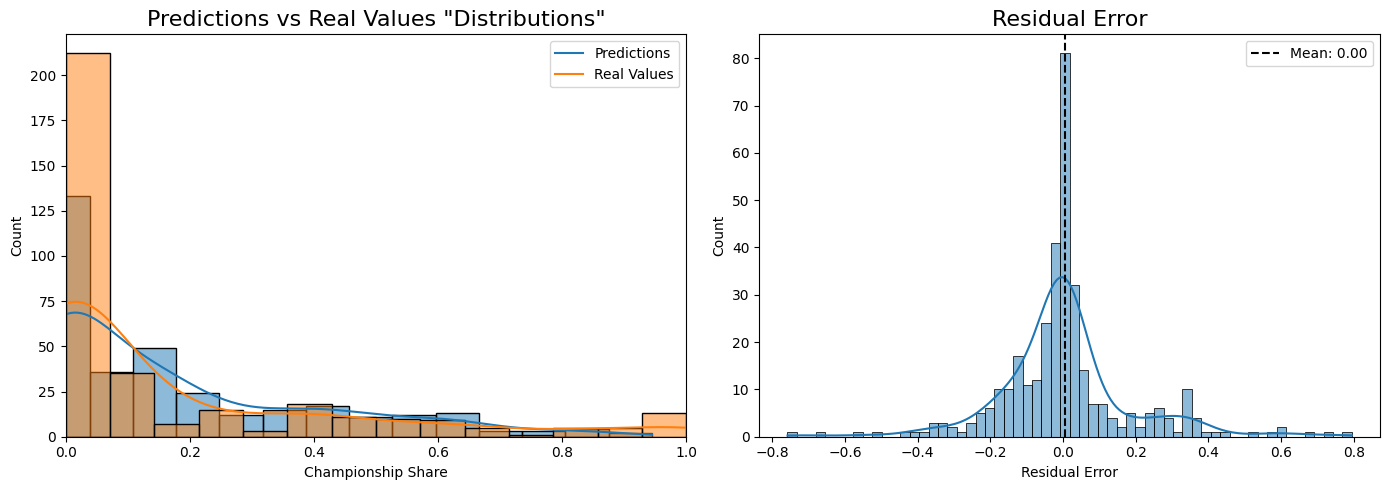

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# === Left Plot: Predictions vs Real Values ===
sns.histplot(Xtest['SCORE'], kde=True, ax=axes[0])
sns.histplot(Xtest['CLASSE'], kde=True, ax=axes[0])
axes[0].legend(['Predictions', 'Real Values'])
axes[0].set_xlim(0, 1)
axes[0].set_title('Predictions vs Real Values "Distributions"', fontsize=16)
axes[0].set_xlabel('Championship Share')

# === Right Plot: Residuals ===
residuos = Xtest['CLASSE'] - Xtest['SCORE']
sns.histplot(residuos, kde=True, ax=axes[1])
axes[1].axvline(residuos.mean(), color='black', linestyle='dashed', label=f'Mean: {residuos.mean():.2f}')
# axes[1].axvline(residuos.median(), color='green', linestyle='dashed', label=f'Median: {residuos.median():.2f}')
axes[1].legend()
axes[1].set_title('Residual Error', fontsize=16)
axes[1].set_xlabel('Residual Error')

plt.tight_layout()
plt.savefig(path_save+sep+'model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


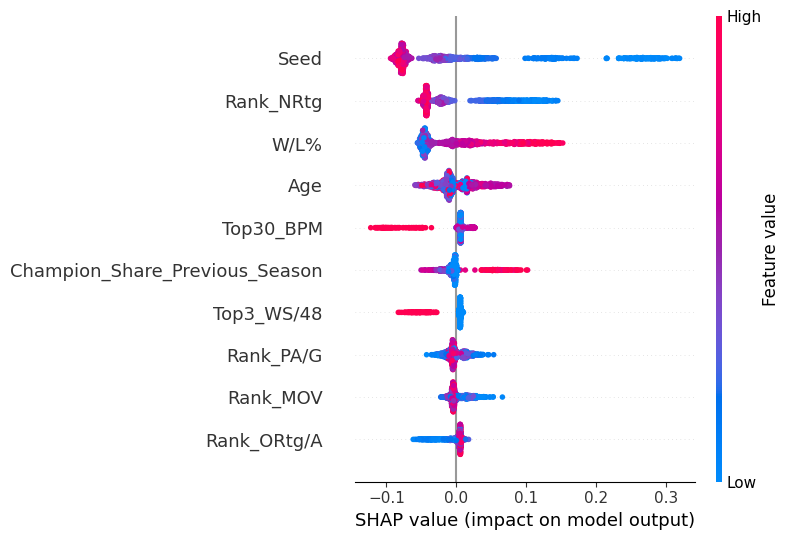

In [42]:
### SHAP ###
explainer = shap.TreeExplainer(model_t_lgbm)

shap_values = explainer.shap_values(df[features])
shap.summary_plot(shap_values, df[features], max_display=10)

In [43]:
champions = pd.DataFrame()

for season in teste['Season'].unique():
    
    season_df = df[df['Season']==season]

    season_df['SCORE'] = model_t_lgbm.predict(season_df.loc[:,features])
    season_df = season_df.sort_values(by='SCORE',ascending=False)

    pred_1 = season_df['Tm'].iloc[0]
    pred_2 = season_df['Tm'].iloc[1]
    pred_3 = season_df['Tm'].iloc[2]

    season_df = season_df.sort_values(by='CLASSE',ascending=False)
    
    apoio = pd.DataFrame([{'Season':season,
                           'Pred. Champion':pred_1, 'Pred. 2nd place':pred_2,
                           'Pred. 3rd place':pred_3,
                           'Champion':season_df['Tm'].iloc[0],
                           '2nd place':season_df['Tm'].iloc[1],
                           '3rd place':season_df['Tm'].iloc[2]}])
    
    champions = pd.concat([champions,apoio],ignore_index=True)

champions['CORRETO'] = (champions['Pred. Champion']==champions['Champion']).astype(int)
print('Model got',str(round(champions['CORRETO'].sum()/len(champions)*100,1)),'% champions right')
champions.sort_values('Season')

Modelo acertou 41.7 dos campeões


,Season,Pred. Champion,Pred. 2nd place,Pred. 3rd place,Champion,2nd place,3rd place,CORRETO
0,1990,LAL,POR,DET,DET,POR,CHI,0
1,1997,CHI,MIA,UTA,CHI,UTA,HOU,1
2,2000,IND,PHO,MIN,LAL,IND,POR,0
3,2002,SAS,LAL,DAL,LAL,NJN,SAC,0
4,2004,SAS,IND,MIN,DET,LAL,IND,0
5,2008,BOS,DET,LAL,BOS,LAL,DET,1
6,2010,ORL,CLE,LAL,LAL,BOS,ORL,0
7,2015,ATL,GSW,HOU,GSW,CLE,HOU,0
8,2017,GSW,SAS,BOS,GSW,CLE,BOS,1
9,2022,GSW,MEM,PHO,GSW,BOS,MIA,1


## Predicting 2025 Playoffs

In [44]:
atual = df[df['Season']==2025]

atual['SCORE'] = model_t_lgbm.predict(atual.loc[:,features])
atual = atual.sort_values(by='SCORE',ascending=False)
atual[['Tm','SCORE']+features].head()

,Tm,SCORE,W/L%,Seed,Rank_PS/G,Rank_PA/G,Rank_SRS,COACHES_Seasons_Franchise,COACHES_Seasons_Career,Age,...,Rank_MOV,Rank_ORtg,Rank_DRtg,Rank_NRtg,Rank_MOV/A,Rank_ORtg/A,Rank_DRtg/A,Rank_NRtg/A,Champion_Share_Previous_Season,Champion_Share_Last_3_Seasons
83,BOS,0.740824,0.744,3,8,2,3,3.0,3.0,27.923077,...,3,2,5,3,3,2,7,3,1.0000,0.854167
201,CLE,0.435444,0.780,2,1,11,2,1.0,5.0,26.928571,...,2,1,8,2,2,1,8,2,0.3125,0.125000
786,OKC,0.397160,0.829,1,4,3,1,5.0,5.0,24.500000,...,1,3,1,1,1,3,1,1,0.3750,0.125000
769,NYK,0.330063,0.622,5,9,9,9,5.0,13.0,26.909091,...,8,5,13,8,9,5,15,9,0.4375,0.270833
369,GSW,0.282129,0.585,13,15,8,10,11.0,11.0,27.466667,...,10,15,7,10,10,14,6,10,0.0000,0.458333
